In [1]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

sys.path.append("/home/wangrr/Analysis/epiRNA/src")
workdir = "/data/wangrr/Analysis/epiRNA/workdir2/benchmark"
os.makedirs(workdir, exist_ok=True); os.chdir(workdir)
warnings.filterwarnings("ignore", category=UserWarning)

import epiRNA as erna

In [61]:
# model config:
config = "/home/wangrr/Analysis/epiRNA/src/experiments/model_v2/configs/basic_model.yaml"

# model checkpoint:
ckpt_dir = "/data/wangrr/Analysis/epiRNA/models"
#checkpoint = f"{ckpt_dir}/basic_full/version_0/checkpoints/epoch=28-step=360122-val_ePCC_mixed=0.9010.ckpt"
checkpoint = f"{ckpt_dir}/basic_fold/version_0/checkpoints/epoch=18-step=215327-val_ePCC_mixed=0.7823.ckpt"

model = erna.evals.load_model(checkpoint, config)
model.eval()

EpiRNAModel(
  (position_encoding): CosinePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (rbp_encoder): RBPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=2140, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=64, out_features=16, bias=True)
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): GELU(approximate='none')
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=16, out_features=512, bias=True)
    )
  )
  (input_conv): SeperatedConvTower(
    (seq_actfn): StableExponential()
    (rna_actfn): Softplus(beta=1.0, threshold=20.0)
    (seq_branch): ModuleList(
      (0): Sequential(
        (0): Conv1d(4, 512, kernel_size=(17,), stride=(1,), padding=same)
        (1): BatchNorm1d(512, eps=1e-05, momen

In [3]:
datainfo = pd.read_excel("/home/wangrr/Analysis/epiRNA/data/mRNA_multiomic_sample_info.xlsx", sheet_name="m6A")

test_samples = ['293T-1', 'Cerebellum-1', 'Cerebrum-1', 'Heart-1', 'Jurkat-1', 'K562-1', 'Lung-1', 'Rectum-1', 'Spleen-1', 'Thyroid_gland-1', 'MONO-MAC-6-1', 'MSC-1', 'HEK293A-TOA-1']

human_datainfo = datainfo[datainfo["SID"].isin(test_samples)].reset_index(drop=True).copy()

ref_dir = "/data/wangrr/Analysis/epiRNA/Dataset/Reference"
genome = {
    "human":{
        "fasta": f"{ref_dir}/Homo_sapiens.GRCh38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Homo_sapiens.GRCh38.84.gtf"
    },
    "mouse":{
        "fasta": f"{ref_dir}//Mus_musculus.GRCm38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Mus_musculus.GRCm38.84.gtf"
    }
}

human_gtf_df = erna.pp.GTFLoader(gtf_path=genome["human"]["gtf"], zero_based=True)
mouse_gtf_df = erna.pp.GTFLoader(gtf_path=genome["mouse"]["gtf"], zero_based=True)

chrom_kwargs = {
    'human': {
        'train_chroms': [],
        'val_chroms': [str(i) for i in range(1,23)],
        'test_chroms': []
    },
    'mouse': {
        'train_chroms': [],
        'val_chroms': [str(i) for i in range(1,21)],
        'test_chroms': []
    }
}

import pickle
with open("/home/wangrr/Analysis/epiRNA/data/rbp_expression_dict.pkl", "rb") as f:
    rbp_dict = pickle.load(f)['rbp_dict']
bigwig_dir = "/data/wangrr/Analysis/epiRNA/Dataset/processed/4-coverage"

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


In [4]:
human_fasta_loader = erna.pp.FastaLoader(genome["human"]["fasta"])
mouse_fasta_loader = erna.pp.FastaLoader(genome["mouse"]["fasta"])

mouse_generator = erna.pp.DataGenerator(
    fasta_loader=mouse_fasta_loader,
    gtf_df=mouse_gtf_df,
    seq_len=65536,
    bin_size=64
)

human_generator = erna.pp.DataGenerator(
    fasta_loader=human_fasta_loader,
    gtf_df=human_gtf_df,
    seq_len=65536,
    bin_size=64
)

In [5]:
# help function to get prediction from given sample-gene pairs using given model
def get_predictions(model, sample, gene, rbp_dict, mask_type, device="cuda:0"):
    sample_info = datainfo[datainfo["SID"]==sample].iloc[0]
    species = sample_info["Species"]
    rbp_exp = rbp_dict[sample]
    
    generator = human_generator if species=="Human" else mouse_generator
    gtf_df = human_gtf_df if species=="Human" else mouse_gtf_df
    
    gene_row = gtf_df[gtf_df["gene_name"]==gene].iloc[0]
    input_bw = erna.pp.BigWigLoader(os.path.join(bigwig_dir, "m6A", "Input", f"{sample}.bigwig"))
    ip_bw = erna.pp.BigWigLoader(os.path.join(bigwig_dir, "m6A", "IP", f"{sample}.bigwig"))
    data = generator.generate(
        gtf_row=gene_row,
        input_bwloader=input_bw,
        ip_bwloader=ip_bw,
        return_bin_input=True,
        mask_type=mask_type
    )
    
    head = 0 if species=="Human" else 1
    
    input_x = torch.tensor(data["input"]).unsqueeze(0).to(device, dtype=torch.float32)
    head_idx = torch.tensor(head).unsqueeze(0).to(device, dtype=torch.long)
    rbp_x = torch.tensor(rbp_exp).unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        preds, attns = model(input_x, rbp_x, head_idx)
        
    preds = preds.squeeze(0).cpu()
    pcc_rna_ip = erna.nn.safe_pearson_corrcoef(
        torch.from_numpy(data["bin_input"]),
        torch.from_numpy(data["target"])
    )
    pcc_pred_ip = erna.nn.safe_pearson_corrcoef(
        torch.from_numpy(data["target"]),
        preds
    )
    loss_rna_ip = nn.MSELoss()(torch.from_numpy(data["bin_input"]), torch.from_numpy(data["target"])).item()
    loss_pred_ip = nn.MSELoss()(torch.from_numpy(data["target"]), preds).item()
    return {
        "gene": gene,
        "chrom": data['region']['chrom'],
        "strand": gene_row['strand'],
        "requested_start": data['region']['requested_start'],
        "requested_end": data['region']['requested_end'],
        "species": species,
        "sample": sample,
        "preds": preds.numpy(),
        "bin_input": data["bin_input"],
        "target": data["target"],
        "pcc_rna_ip": pcc_rna_ip,
        "pcc_pred_ip": pcc_pred_ip,
        "loss_rna_ip": loss_rna_ip,
        "loss_pred_ip": loss_pred_ip
    }
    

In [6]:
test_samples

['293T-1',
 'Cerebellum-1',
 'Cerebrum-1',
 'Heart-1',
 'Jurkat-1',
 'K562-1',
 'Lung-1',
 'Rectum-1',
 'Spleen-1',
 'Thyroid_gland-1',
 'MONO-MAC-6-1',
 'MSC-1',
 'HEK293A-TOA-1']

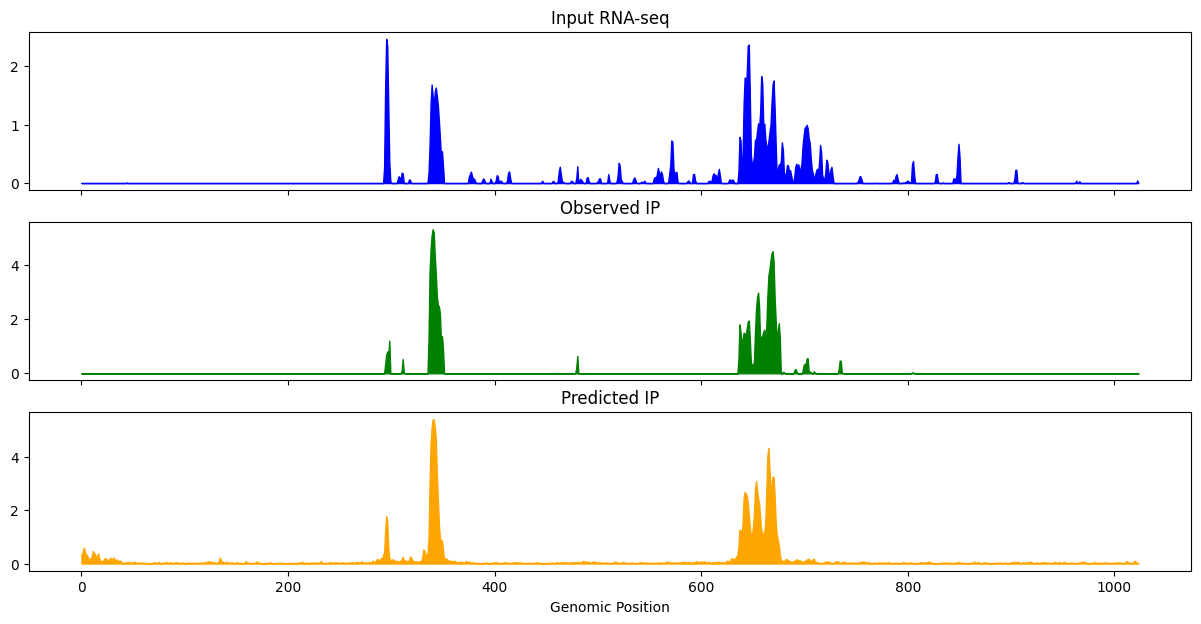

{'gene': 'REST',
 'chrom': '4',
 'strand': '+',
 'requested_start': 56889092,
 'requested_end': 56954628,
 'species': 'Human',
 'sample': 'Spleen-1',
 'preds': array([0.35328335, 0.38290998, 0.5860927 , ..., 0.02893491, 0.01658738,
        0.02449663], dtype=float32),
 'bin_input': array([0.        , 0.        , 0.        , ..., 0.        , 0.04389136,
        0.        ], dtype=float32),
 'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pcc_rna_ip': tensor(0.7439),
 'pcc_pred_ip': tensor(0.9446),
 'loss_rna_ip': 0.18372255563735962,
 'loss_pred_ip': 0.04235959053039551}

In [104]:
#sample = "Cerebellum-1"
sample = "Spleen-1"
gene = "REST"

out = get_predictions(
    model.cuda(), 
    sample=sample, 
    gene=gene, 
    rbp_dict=rbp_dict, 
    mask_type=None, 
    device="cuda"
)
erna.pl.multiple_tracks_plot(
    input_obs=out['bin_input'],
    ip_obs=out['target'],
    ip_pred=out['preds'],
    actmap=None,
    figsize=(15,7)
)
out

In [105]:
# save to bigwig
save_dir = "./predicted_bigwig"
os.makedirs(save_dir, exist_ok=True)
bw_path = os.path.join(save_dir, f"{sample}_{gene}_fullmodel.bigwig")
erna.pp.bioloader.coverage_to_bigwig(
    coverage=out['preds'],
    chrom=out['chrom'],
    start=out['requested_start'],
    end=out['requested_end'],
    strand=out["strand"],
    chrom_sizes=human_fasta_loader.chr_sizes,
    output_path=bw_path
)

bigWig file created: ./predicted_bigwig/Spleen-1_REST_fullmodel.bigwig
Total intervals: 1,024
Value range: [0.0074, 5.4047]


'./predicted_bigwig/Spleen-1_REST_fullmodel.bigwig'

In [98]:
ls ./predicted_bigwig

Cerebellum-1_GABRA1_fullmodel.bigwig  Heart-1_SOX2_fullmodel.bigwig
Cerebellum-1_NOTCH1_fullmodel.bigwig  Hela-1_YTHDF3_complete.bigwig
Cerebellum-1_REST_fullmodel.bigwig    Hela-1_YTHDF3_maskrbp.bigwig
Cerebellum-1_SOX2_fullmodel.bigwig    Hela-1_YTHDF3_maskrna.bigwig
Cerebrum-1_GABRA1_fullmodel.bigwig    Hela-1_YTHDF3_maskseq.bigwig
Cerebrum-1_REST_fullmodel.bigwig      Jurkat-1_GABRA1_fullmodel.bigwig
Cerebrum-1_SOX2_fullmodel.bigwig      Lung-1_REST_fullmodel.bigwig
Heart-1_PTEN_fullmodel.bigwig         Spleen-1_REST_fullmodel.bigwig
